# Mental Attention States Classification Using EEG Data

### Pattern Recognition - Mid-term project - Group 3

| **Full name**          | **Student ID** |
|------------------------|----------------|
| Lê Hồng Cát            |  21110249      |       
| Trương Minh Hoàng      |  22280034      |
| Đặng Minh Phúc         |  22280064      |
| Trần Nguyễn Trung Tuấn |  22280101      |


# Outline
- [ 1 - Objective ](#1)
- [ 2 - Data Preprocessing ](#2)
- [ 3 - Feature Engineering ](#3)
- [ 4 - Model Development ](#4)
- [ 5 - Analysis and Visualization ](#5)
- [ 6 - Self-Assessment ](#7)

<a name="1"></a>
# 1. Objective

 Classify mental attention states (focused, unfocused, drowsy) based on EEG signals using
 machine learning techniques.

__Dataset Details:__
 - Dataset URL: https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data
 - Data was acquired from EMOTIV EEG devices during 34 experiments.
 - EEG data is in channels 4 to 17 of the provided Matlab files.
 - Sampling frequency: 128 Hz.

<a name="2"></a>
# 2. Data Preprocessing

## Read data

The list of data channels and their numerical ids is given below per EMOTIV documentation:

1. 'ED_COUNTER'
2. 'ED_INTERPOLATED'
3. 'ED_RAW_CQ'
4. 'ED_AF3'
5. 'ED_F7'
6. 'ED_F3'
7. 'ED_FC5'
8. 'ED_T7'
9. 'ED_P7'
10. 'ED_O1'
11. 'ED_O2'
12. 'ED_P8'
13. 'ED_T8'
14. 'ED_FC6'
15. 'ED_F4'
16. 'ED_F8'
17. 'ED_AF4'
18. 'ED_GYROX'
19. 'ED_GYROY'
20. 'ED_TIMESTAMP'
21. 'ED_ES_TIMESTAMP'
22. 'ED_FUNC_ID'
23. 'ED_FUNC_VALUE'
24. 'ED_MARKER'
25. 'ED_SYNC_SIGNAL'

The EEG data is in the channels 4:17.

Our data will be labeled with the following focus states:
- __focused:__ the first 10 minutes
- __unfocused:__ from 10 to 20 minutes
- __drowsy:__ from 20 minutes onward

In [2]:
import mne
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path = './data/eeg_record1.mat'

# Load the .mat file
mat_data = loadmat(path)

# Inspect the content of the .mat file
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'o'])


In [3]:
eeg_data = mat_data['o']
type(eeg_data)

numpy.ndarray

In [4]:
eeg_data[0][0]['data']

array([[  3.,   0., 463., ...,   0.,   0.,   0.],
       [  4.,   0.,   0., ...,   0.,   0.,   0.],
       [  5.,   0., 447., ...,   0.,   0.,   0.],
       ...,
       [ 25.,   0.,   0., ...,   0.,   0.,   0.],
       [ 26.,   0.,   0., ...,   0.,   0.,   0.],
       [ 27.,   0.,   0., ...,   0.,   0.,   0.]])

In [5]:
# The EEG data is in the channels 4 to 17 (columns index 3:17)
data = eeg_data[0][0]['data'][:, 3:17]
data.shape

(308868, 14)

Our data currently has the shape __(n_samples, n_channels)__, where __n_samples = time_in_seconds * sampling_frequency__. Moreover, our EEG data includes a total of 14 channels.

We will transform our data into a DataFrame for better visualization across the channels.

In [6]:
# EEG data's channels
channels = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
    'O2',  'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4',
]

df = pd.DataFrame(data, columns=channels)

At this point, the index in our DataFrame corresponds to _time_in_seconds * sampling_frequency_. We will add the target variable `state` to visualize the importance of the channels in relation to the target variable.

In [7]:
df['state'] = np.nan # Tạo cột 'state'
df['state'][:10*60*128] = 'focused'  # 10 phút đầu là 'focused'
df['state'][10*60*128:20*60*128] = 'unfocused'  # 10 phút tiếp theo là 'unfocused'
df['state'][20*60*128:] = 'drowsy'  # Từ phút 20 trở đi là 'drowsy'

C:\Users\dangm\AppData\Local\Temp\ipykernel_13152\1006839415.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['state'][:10*60*128] = 'focused'  # 10 phút đầu là 'focused'
C:\Users\dangm\AppData\Local\Temp\ipykernel_13152\1006839415.py:

In [8]:
df['state'].value_counts()

state
drowsy       155268
focused       76800
unfocused     76800
Name: count, dtype: int64

In the experiment, the _drowsy_ state will appear much more frequently than the other two states (approximately twice as much compared to the current file).

We will try to visualize the correlation between the `channels` with each other, as well as between the `channels` and the `state`.

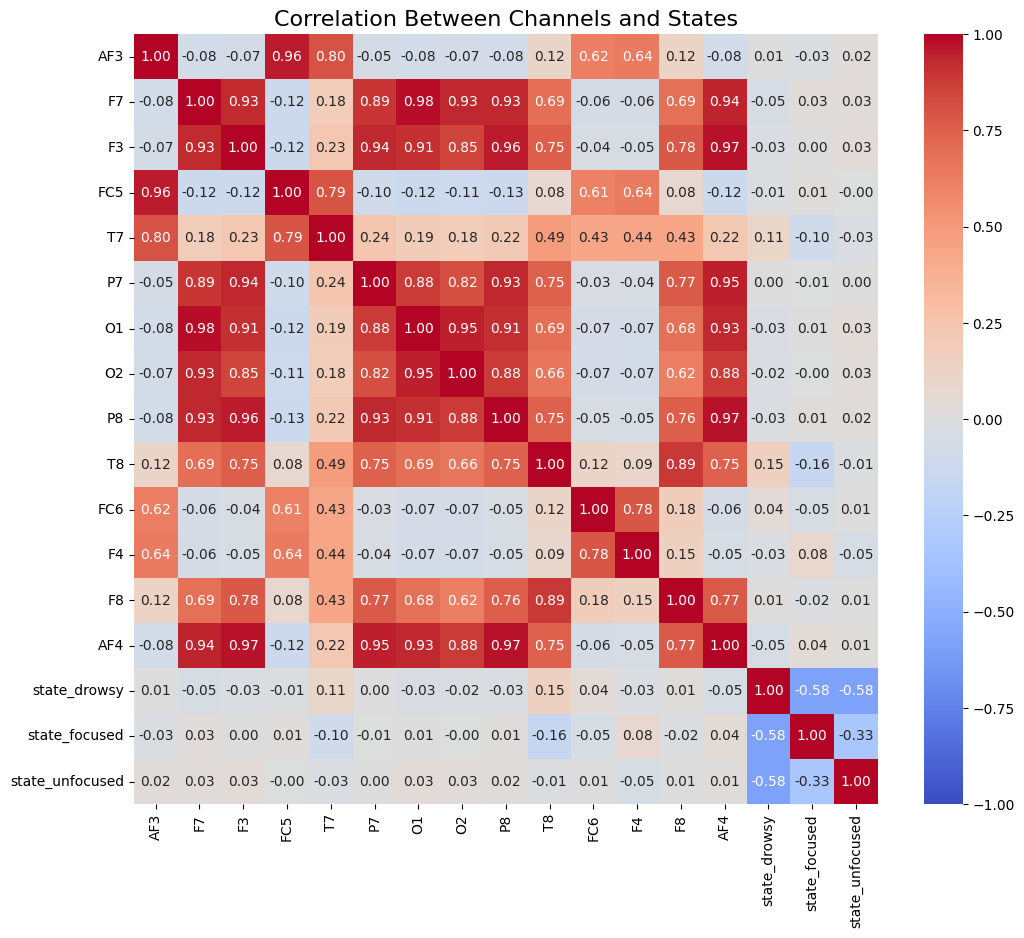

In [9]:
import seaborn as sns

# Sử dụng phương pháp One-Hot Encoding cho cột 'state'
df_encoded = pd.get_dummies(df['state'], prefix='state')

# Kết hợp các cột 'state' đã được mã hóa với dữ liệu EEG
df_final = pd.concat([df.drop(columns='state'), df_encoded], axis=1)

# Tính ma trận tương quan
correlation = df_final.corr()

# Vẽ ma trận tương quan sử dụng seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Channels and States', fontsize=16)
plt.show()

However, in EEG classification problems, the target variable often has a nonlinear relationship with the `channels`. Therefore, we can use Mutual Information (MI) to gain more insights into the relationship between the `channels` and detecting attention states.

<Figure size 2500x600 with 0 Axes>

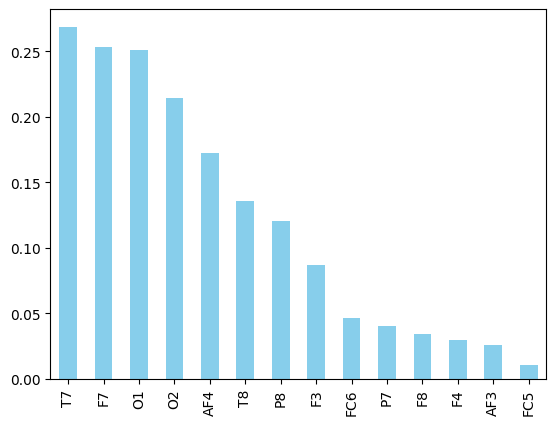

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Giả sử bạn đã có DataFrame df_final với các kênh EEG và các cột state đã mã hóa (sau khi One-Hot Encoding)
# Lấy các features và target
X = df_final.drop(columns=['state_focused', 'state_unfocused', 'state_drowsy'])  # Các cột EEG
y = df_final[['state_focused', 'state_unfocused', 'state_drowsy']].idxmax(axis=1)  # Chuyển các trạng thái thành nhãn phân loại

def plot_mutual_information(X, y):
    # Tính Mutual Information giữa các kênh EEG và target (state)
    mi = mutual_info_classif(X, y)

    # Chuyển kết quả Mutual Information thành DataFrame để dễ dàng trực quan hóa
    mi_df = pd.DataFrame(mi, index=X.columns, columns=['Mutual Information'])

    # Sắp xếp các giá trị Mutual Information từ cao đến thấp
    mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

    # Vẽ bar plot cho Mutual Information
    plt.figure(figsize=(25, 6))
    mi_df.plot(kind='bar', legend=False, color='skyblue')
    plt.xticks(rotation=90)
    plt.show()

plot_mutual_information(X, y)

We can observe that `T7` and `T8` show a high correlation when measured using correlation for the _drowsy_ and _focused_ states.

When measured using the MI score, `T7` remains a very important channel for classifying attention states. Other channels that also hold significant importance are `F7` and `O1`.

### Use MNE package to extract raw data

We will process our data using the MNE package, which is an excellent tool for exploring, visualizing, and analyzing EEG data. This package includes a tool for visualizing the channels on the brain, allowing us to see the spatial locations of the channels and facilitating the analysis of correlation plots.

To streamline our workflow, we will encapsulate the functions at each step so they can be reused when processing all files.
We will transpose the original data array to give it the shape _(n_channels, n_samples)_ to match the RawArray format required by the MNE package.

In [11]:
data = data.T
data.shape

(14, 308868)

In [12]:
sampling_freq = 128

info = mne.create_info(channels, sampling_freq, ch_types='eeg')
raw_data = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=14, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


In [13]:
raw_data.get_data()

array([[4440.        , 4439.48717949, 4438.97435897, ..., 4441.53846154,
        4441.53846154, 4444.61538462],
       [4417.94871795, 4417.94871795, 4414.87179487, ..., 4554.87179487,
        4556.41025641, 4546.15384615],
       [5390.76923077, 5389.23076923, 5385.64102564, ..., 5613.84615385,
        5610.25641026, 5605.64102564],
       ...,
       [4283.58974359, 4284.61538462, 4283.07692308, ..., 4285.12820513,
        4283.58974359, 4283.07692308],
       [4335.38461538, 4331.79487179, 4333.84615385, ..., 4334.87179487,
        4334.35897436, 4334.87179487],
       [4563.58974359, 4566.66666667, 4557.94871795, ..., 4701.02564103,
        4696.92307692, 4694.35897436]])

In [14]:
raw_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

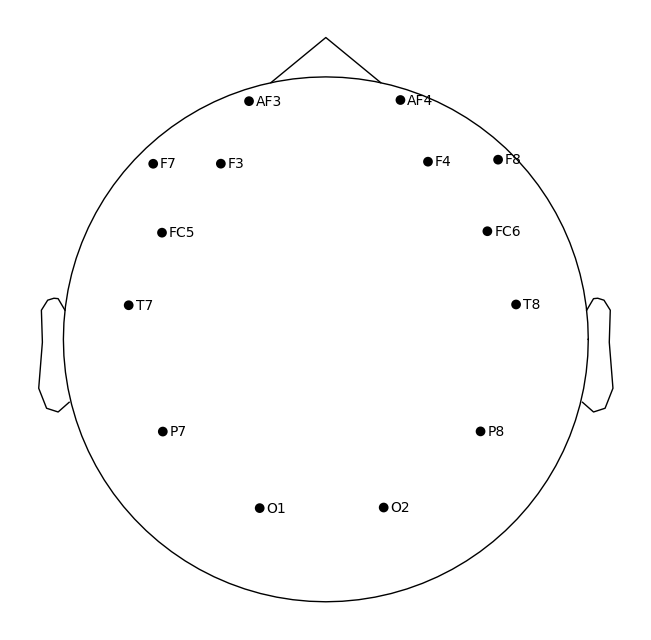

In [15]:
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage)

raw_data.plot_sensors(show_names=True)
plt.show()

We can observe that the channels `T7` and `T8` (the two channels with higher correlation compared to others) are symmetrically located on the head (in the left and right temporal regions).

The channels `F7` and `O1` (the two channels with high MI scores) are also located on the left side of the head, like `T7`. Based on this, we can hypothesize that the left hemisphere of the brain might play a significant role in determining human attention states.

In [16]:
raw_data

<RawArray | 14 x 308868 (2413.0 s), ~33.0 MB, data loaded>

In [17]:
def show_graphs(raw_data, rate=1.0):
    # Extract data and times
    data, times = raw_data.get_data(return_times=True)
    channels = raw_data.info['ch_names']
    n_channels = len(channels)

    # Limit data based on the specified rate
    max_samples = int(len(times) * rate)
    data = data[:, :max_samples]
    times = times[:max_samples]

    # Create subplots
    fig, ax = plt.subplots(
        n_channels, 1, figsize=(15, n_channels * 4), sharex=True
    )

    for i in range(n_channels):
        ax[i].plot(times, data[i], lw=0.8)
        ax[i].set_ylabel(channels[i], rotation=0, labelpad=20, fontsize=12)
        ax[i].grid(True, linestyle='--', alpha=0.5)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

    # Set x-axis label for the last subplot
    ax[-1].set_xlabel('Time (s)', fontsize=14)

    # Adjust subplot spacing
    fig.subplots_adjust(hspace=0.5)
    plt.show()


# show_graphs(raw_data, rate=0.01)

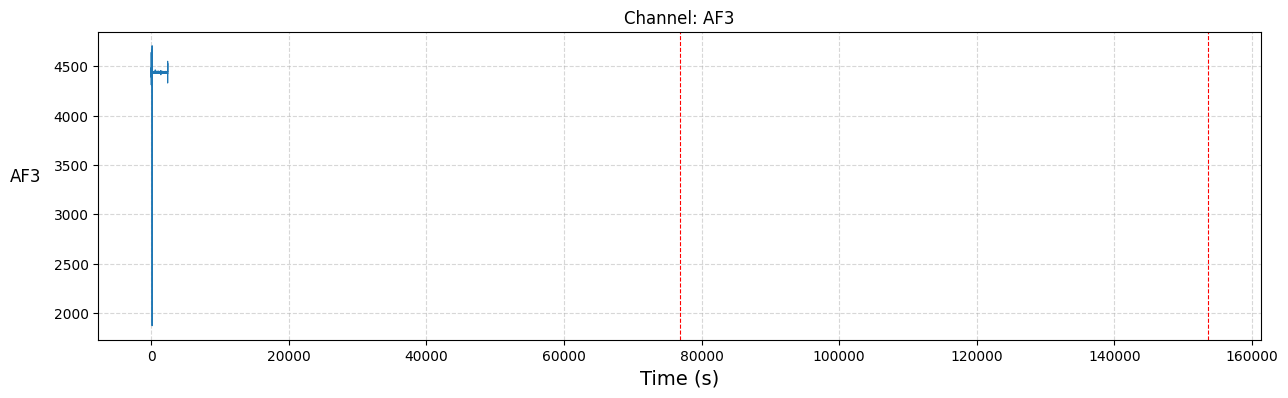

In [18]:
def show_channel(raw_data, channel_name, rate=1.0):
    # Extract data and times
    data, times = raw_data.get_data(return_times=True)
    channels = raw_data.info['ch_names']
    
    # Find the index of the specified channel
    if channel_name not in channels:
        raise ValueError(f"Channel {channel_name} not found in raw data.")
    channel_idx = channels.index(channel_name)
    
    # Limit data based on the specified rate
    max_samples = int(len(times) * rate)
    data = data[channel_idx, :max_samples]
    times = times[:max_samples]

    # Create the plot
    plt.figure(figsize=(15, 4))
    plt.plot(times, data, lw=0.8)
    plt.ylabel(channel_name, rotation=0, labelpad=20, fontsize=12)
    plt.xlabel('Time (s)', fontsize=14)
    plt.axvline(x=10*128*60*rate, color='red', linestyle='--', lw=0.8)
    plt.axvline(x=20*128*60*rate, color='red', linestyle='--', lw=0.8)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f'Channel: {channel_name}')
    plt.show()


show_channel(raw_data, 'AF3')

In [19]:
10*128*60

76800

In [20]:
data, times = raw_data.get_data(return_times=True)
len(times)

308868

As mentioned, before concluding the raw data extraction phase, we will encapsulate the process into reusable functions to facilitate its use in subsequent steps.

In [21]:
def extract_raw_data(file_path: str, channel_names: list, sfreq: int) -> tuple:
    """Load and structure EEG data into MNE format."""
    # Load data
    from scipy.io import loadmat
    mat_file = loadmat(file_path)
    data = mat_file['o'][0][0]['data'][:, 3:17]  # EEG data

    # Create MNE Raw object
    info = mne.create_info(channel_names, sfreq, ch_types="eeg")
    raw = mne.io.RawArray(data.T, info)

    # Split into conditions
    focus_data = raw.copy().crop(tmin=0, tmax=10 * 60)
    unfocus_data = raw.copy().crop(tmin=10 * 60, tmax=20 * 60)
    drowsy_data = raw.copy().crop(tmin=20 * 60)

    return [focus_data, unfocus_data, drowsy_data]

We will solve our problem by the following pipeline:

<center>
  <img src="pipeline.png" alt="description" />
</center>

## Band-pass filtering

In [22]:
def bandpass_filter(raw: mne.io.Raw, lowcut: float, highcut: float) -> mne.io.Raw:
    """Apply bandpass filter using MNE."""
    raw.filter(l_freq=lowcut, h_freq=highcut, method="fir")
    return raw

# Band-pass filter: between 0.5 Hz and 50 Hz
raw_data = bandpass_filter(raw=raw_data, lowcut=0.5, highcut=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (6.602 s)



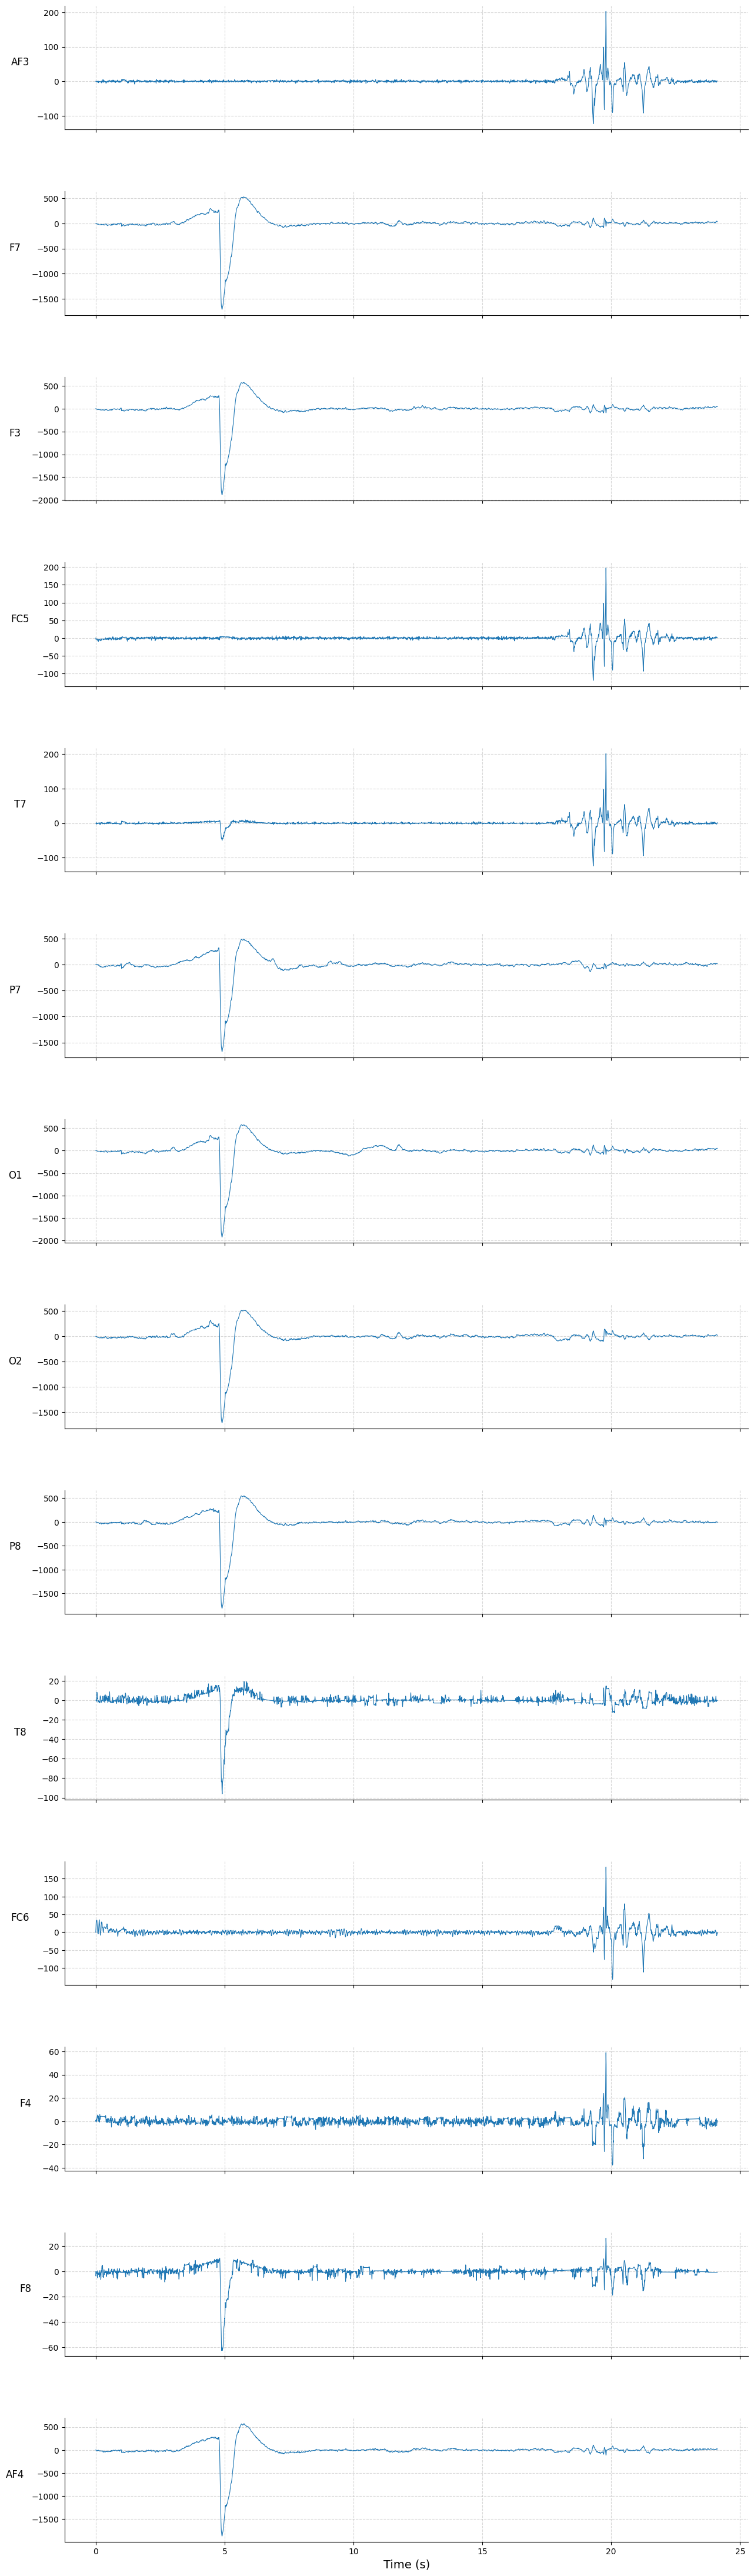

In [23]:
show_graphs(raw_data, rate=0.01)

## Remove artifacts with ICA
In EEG devices, the measured results at each electrode site represent the electromagnetic wave resonance from all brain sources at that location. Therefore, it is necessary to make the measurement results independent of each other. In this study, the authors applied the ICA (Independent Component Analysis) method to separate the measurement results of the channels into independent components. However, this result only shows the independence between the channels, without proving that it is not influenced by external factors such as eye movements, muscle activity, heart rhythm, or noise interference.

In this study, the authors apply specialized knowledge from other medical research studies to identify the components (post-ICA) that are affected by external factors, either partially or throughout the entire measurement process.

We will analyze and find out the components which are artifacts. (Reference: https://labeling.ucsd.edu/tutorial/labels)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 10.0s.


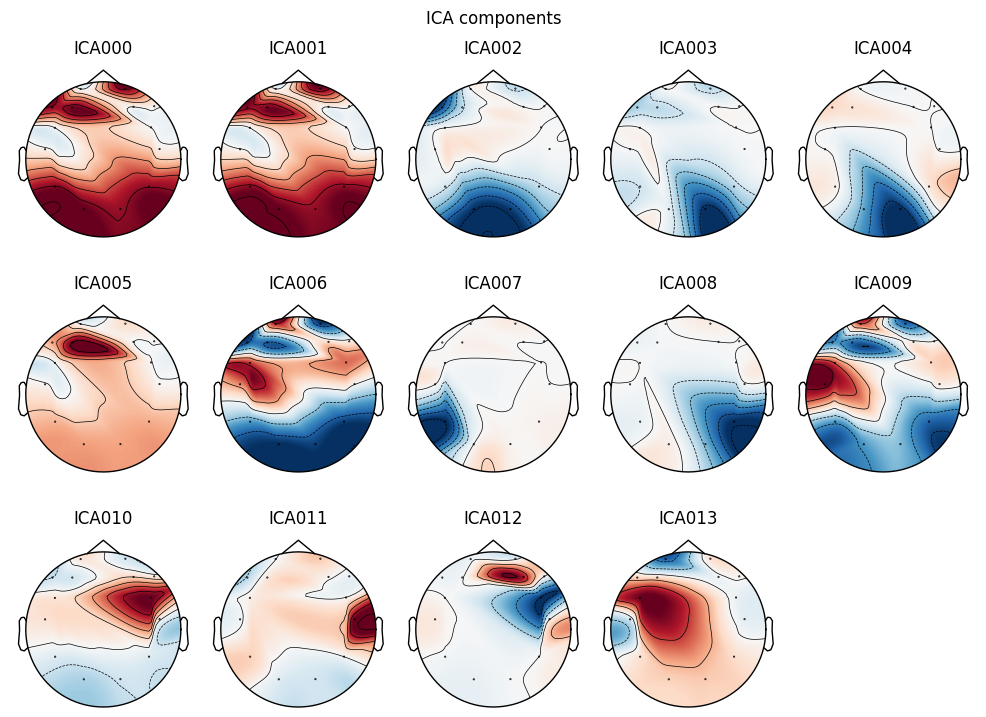

In [24]:
from mne.preprocessing import ICA
import matplotlib.pyplot as plt

# Fit ICA to the raw data
ica = ICA(n_components=14, random_state=42)
ica.fit(raw_data)

ica.plot_components()
plt.show()

Creating RawArray with float64 data, n_channels=14, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Using matplotlib as 2D backend.


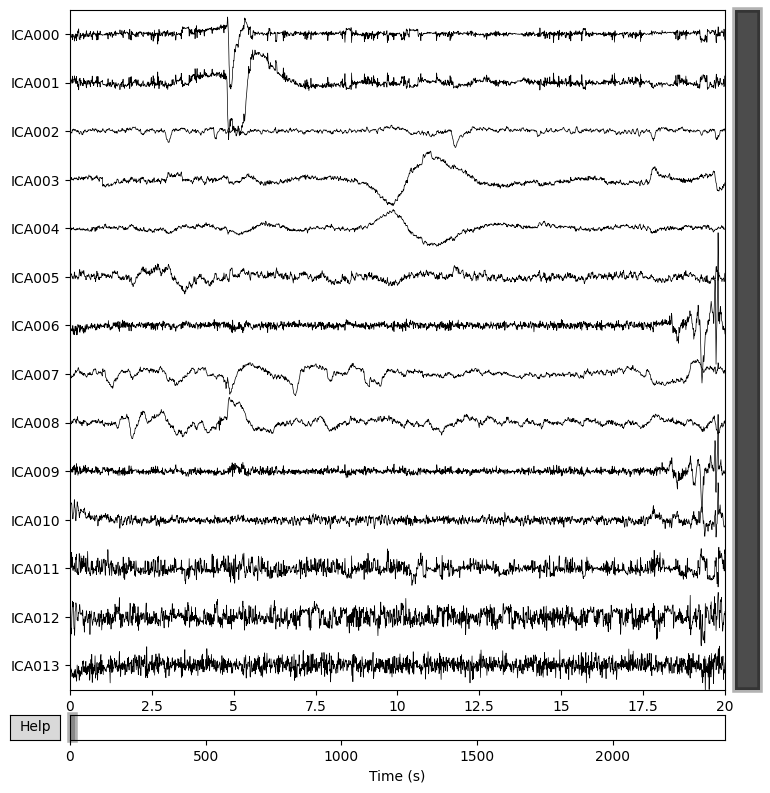

In [25]:
ica.plot_sources(raw_data, use_opengl=True, overview_mode=True)
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1206 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1206 matching events found
No baseline correction applied
0 projection items activated


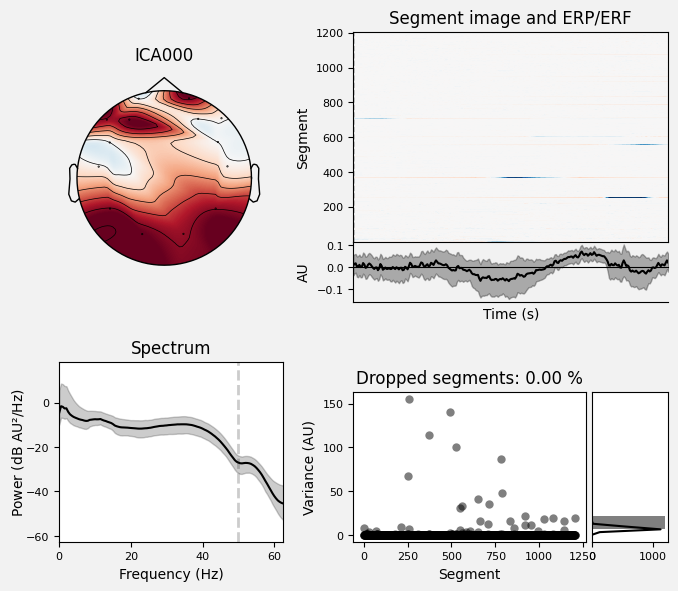

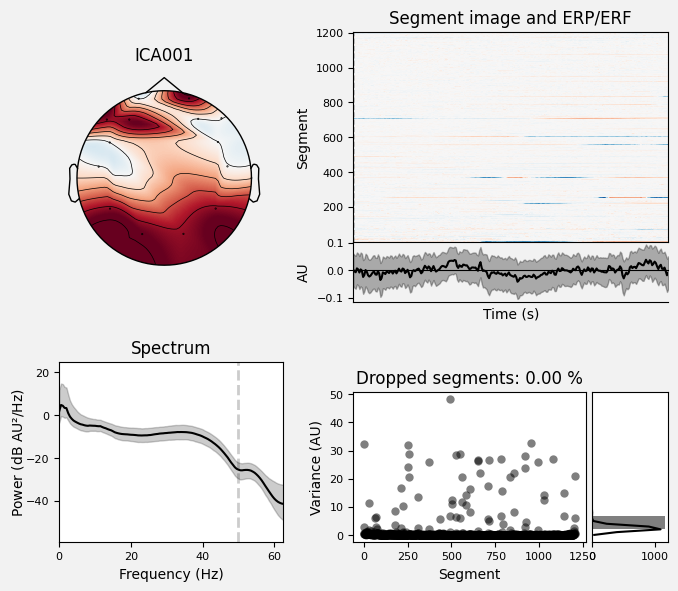

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [26]:
ica.plot_properties(raw_data, picks=[0, 1])

The components `ICA000` and `ICA001` are influenced by __external factors from eye activity__ for the following reasons:
- The EEG time series shows sudden changes in amplitude, with sharp decreases followed by almost linear increases, indicating the presence of vertical movements (e.g., blinking).
- High energy is concentrated in low frequencies (below 5 Hz), which then gradually decreases, as seen in the PSD plot.
- Scalp topographies reveal high energy (indicated by red color gradients) near the eye regions, corresponding to Equivalent Current Dipoles (ECD).


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1206 matching events found
No baseline correction applied
0 projection items activated


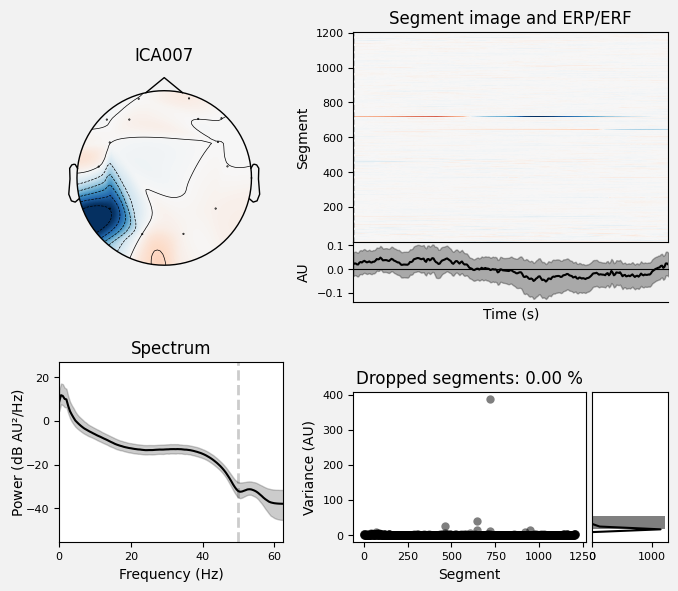

[<Figure size 700x600 with 6 Axes>]

In [27]:
ica.plot_properties(raw_data, picks=[7])

The component `ICA007` is influenced by __heart rhythm__ in the early stage for the following reasons:

- The EEG time series shows large cyclical fluctuations in the early phase, indicating that the participant's heart rate increased, causing interference in the component during the initial phase of the experiment.
- Scalp topographies exhibit a linear pattern (as seen in the gradually decreasing color scale).
- In the PSD plot, at frequency bands below 1 Hz, continuous gradient reversals are a sign of the influence of the QRS complex from the heart's electrical waves. After this, the graph tends to stabilize and show a linear slope.


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1206 matching events found
No baseline correction applied
0 projection items activated


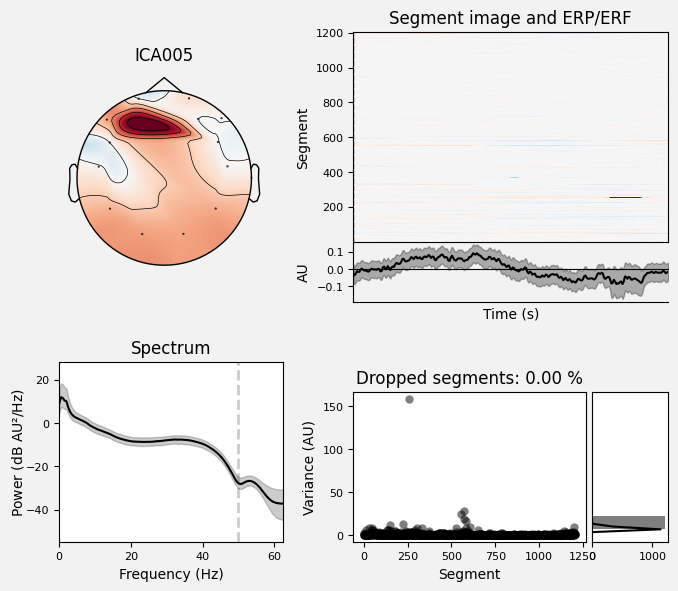

[<Figure size 700x600 with 6 Axes>]

In [28]:
ica.plot_properties(raw_data, picks=[5])

The components `ICA011`, `ICA012`, `ICA013` are noise components caused by __electrical line interference__, as evidenced by a peak in the PSD graph at frequency bands near 50 Hz.
However, the noise components caused by __eye__ and __heart__ activity are the most problematic, so we will remove these components.

In [29]:
áica.exclude = [0, 1, 7]

NameError: name 'áica' is not defined

In [44]:
raw_data = ica.apply(raw_data, exclude=ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components


In [45]:
raw_data

<RawArray | 14 x 308868 (2413.0 s), ~33.0 MB, data loaded>

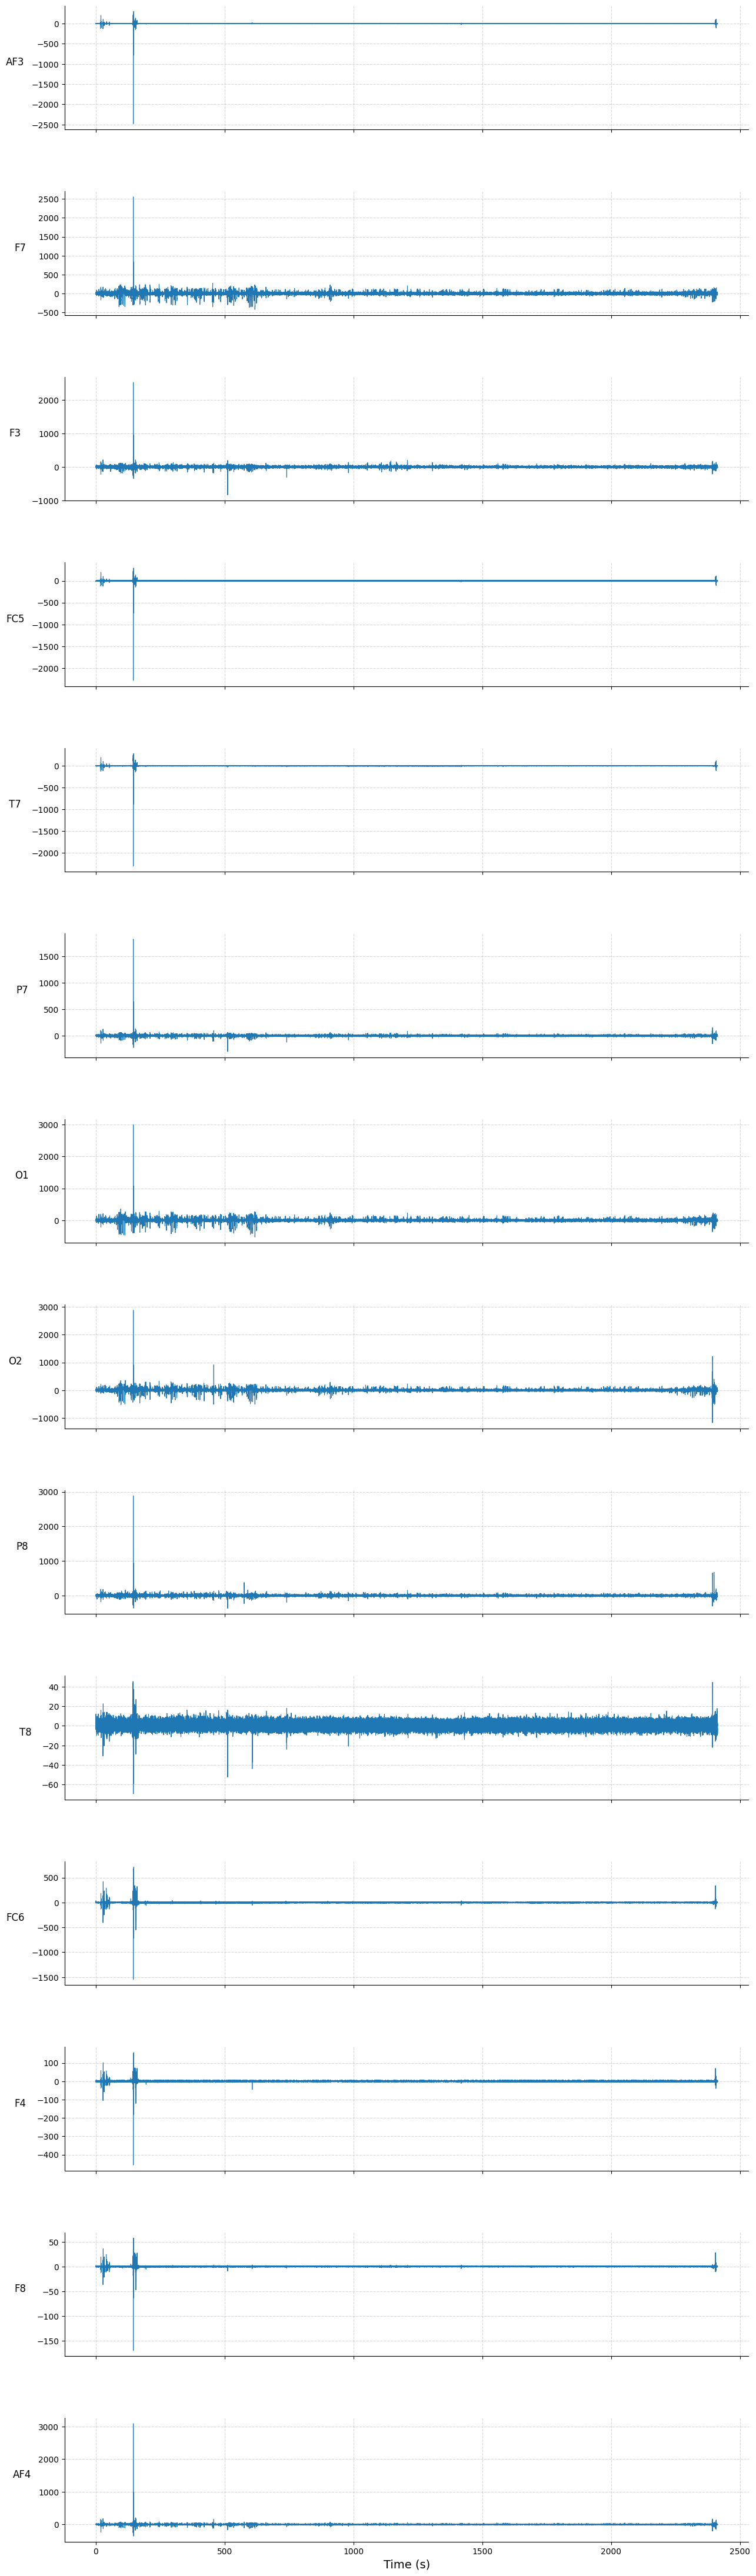

In [46]:
show_graphs(raw_data)

Let's pack the ICA part.

In [ ]:
def apply_ica(raw: mne.io.Raw, n_components: int = None) -> mne.io.Raw:
    """Apply ICA to remove artifacts."""
    if n_components is None:
        n_components = mne.compute_rank(raw, tol=1e-4)['eeg']
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=42, max_iter=500)
    ica.fit(raw)
    raw = ica.apply(raw)
    return raw

End of __Data Processing__ stage we will encapsulate for all this part.

In [ ]:
import copy

def preprocess_eeg(raw_eeg, lowcut, highcut, n_components: int = None):
    filter_eeg = copy.deepcopy(raw_eeg)
    for i in range(len(filter_eeg)):
        filter_eeg[i] = bandpass_filter(filter_eeg[i], lowcut, highcut)

    ica_eeg = copy.deepcopy(filter_eeg)
    for i in range(len(ica_eeg)):
        ica_eeg[i] = apply_ica(ica_eeg[i], n_components)

    return ica_eeg

<a name="3"></a>
# 3. Feature Engineering

## Power spectrum analysis
We need to split the data into 3 sets corresponding to the 3 states in order to easily visualize the results.

In [ ]:
print(f"Path: {path}")
print(f"Channel columns: {channels}")
print(f"Sampling frequency: {sampling_freq}")

The $\texttt{extract\_raw\_data()}$ function will return $\texttt{[focused\_data, unfocused\_data, drowsy\_data]}$

In [ ]:
# Get data for each state
data = extract_raw_data(path, channels, sampling_freq)
processed_data = preprocess_eeg(raw_eeg=data, lowcut=0.5, highcut=50, n_components=14)

We will extract the relevant band powers that are useful for detecting attention states.

In [ ]:
def compute_band_power(raw: mne.io.Raw, fmin, fmax) -> tuple:
    """Compute band power using Welch's method."""

    fs = int(raw.info['sfreq'])
    psds, freqs = raw.compute_psd(method='welch', fmin=fmin, fmax=fmax, n_per_seg = fs*2).get_data(return_freqs=True)

    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 100)}
    band_power_data = {}
    for band, (low, high) in bands.items():
        band_idx = np.logical_and(freqs >= low, freqs < high)
        band_power_data[band] = np.mean(psds[:, band_idx], axis=1)

    return pd.DataFrame(band_power_data), psds, freqs

In [ ]:
focused_df, focused_psd, freqs = compute_band_power(raw=processed_data[0], fmin=0.5, fmax=50)
unfocused_df, unfocused_psd, _ = compute_band_power(raw=processed_data[1], fmin=0.5, fmax=50)
drowsy_df, drowsy_psd, _ = compute_band_power(raw=processed_data[2], fmin=0.5, fmax=50)

In [ ]:
def plot_psd_for_all_states(focused_psd, unfocused_psd, drowsy_psd, freqs, channels):
    plt.figure(figsize=(15, 20))

    # Iterate over channels
    for ch_idx in range(len(channels)):  # Lặp qua các kênh EEG
        plt.subplot(7, 2, ch_idx + 1)

        # Plot the average PSD for each state for the current channel
        plt.semilogy(freqs, focused_psd[ch_idx], label='Focused', color='b', linewidth=2)
        plt.semilogy(freqs, unfocused_psd[ch_idx], label='Unfocused', color='g', linewidth=2)
        plt.semilogy(freqs, drowsy_psd[ch_idx], label='Drowsy', color='r', linewidth=2)

        # Add labels and grid
        plt.title(channels[ch_idx], fontsize=14)  # Dùng tên kênh từ biến 'channels'
        plt.xlabel('Frequency (Hz)', fontsize=12)
        plt.ylabel('Magnitude', fontsize=12)
        plt.grid(linestyle='--')

        # Add legend
        plt.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Plot the PSD for all channels with the 3 states
plot_psd_for_all_states(focused_psd, unfocused_psd, drowsy_psd, freqs, channels)

__Low Frequency (< 10 Hz):__

- Most channels show that the __Focused__ state has a higher amplitude compared to __Unfocused__ and __Drowsy__ in the low-frequency range. This may indicate that during focused attention, EEG activity in the alpha and theta bands becomes more prominent.
- In the __Drowsy__ state, the amplitude is lower and closer to the Unfocused state, reflecting a reduction in brainwave intensity when a person is fatigued or distracted.

__Medium Frequency (10-30 Hz):__

- In the beta range (approximately 13-30 Hz), the amplitude decreases across all states. However, __Focused__ maintains slightly higher amplitudes than the other states, especially in certain channels like `AF3`, `F7`, and `FC5`.
- The difference between states appears smaller compared to the low-frequency range.

__High Frequency (> 30 Hz):__

- The amplitude drops sharply in all states, indicating that gamma wave activity is not dominant in the recorded data.
- The amplitudes of all three states nearly converge, suggesting that distinguishing between states at high frequencies is more challenging.

__Differences Across Channels:__
- Channels in the frontal region (e.g., `AF3`, `F7`, `F8`) show the most noticeable differences between states, particularly in the low-frequency range.
- Channels in the temporal and occipital regions (e.g., `T7`, `T8`, `O1`, `O2`) exhibit less clear distinctions between the Focused and Unfocused states, especially in the medium and high-frequency ranges.

__General Trends:__
- The __Focused__ state typically has higher amplitudes in the low and medium frequency ranges.
- The __Unfocused__ and __Drowsy__ states tend to show a steeper decrease in amplitude across all frequency bands.


In [ ]:
# Define a function to plot PSD for all states on the same plot for all channels
def plot_psd_for_all_states(focused_psd, unfocused_psd, drowsy_psd, freqs, channels):
    # Plot all states on the same plot
    plt.figure(figsize=(12, 8))

    # Plot the PSD for each state
    plt.semilogy(freqs, focused_psd.mean(axis=0), label='Focused', color='b', linewidth=2)
    plt.semilogy(freqs, unfocused_psd.mean(axis=0), label='Unfocused', color='g', linewidth=2)
    plt.semilogy(freqs, drowsy_psd.mean(axis=0), label='Drowsy', color='r', linewidth=2)

    # Add labels and grid
    plt.title('Average PSD Across All Samples and Channels for Each State', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Magnitude', fontsize=14)
    plt.grid(linestyle='--')

    # Add legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot the average PSD for all channels and states on the same plot
plot_psd_for_all_states(focused_psd, unfocused_psd, drowsy_psd, freqs, channels)

__Graph shape:__

- The curve decreases from low to high frequencies, which aligns with the characteristics of physiological signals like EEG, where most energy is concentrated at lower frequencies.

__Comparison between states:__

- At low frequencies (around 0–10 Hz), the Focused state (blue line) shows significantly higher PSD values compared to the other two states (Unfocused and Drowsy). This suggests that the focused state contains more energy in the low-frequency range.

- At medium and high frequencies (above 10 Hz), the differences between the states become less pronounced, and the lines gradually converge.

__Spectral characteristics:__

- The small oscillations in the higher frequency range (> 20 Hz) might relate to noise or specific signal activities.
- The sharp energy drop-off at very high frequencies (> 40 Hz) is consistent with the natural filtering effect of physiological systems.

__Potential significance:__

- The differences between the states can be useful for signal classification or analyzing various neural states. For instance, the higher values in the low-frequency range for the Focused state might correspond to alpha or theta waves.
- Contrast with Domain Knowledge: The higher relax, the greater value of bands in low frequency (<10 Hz)

__Conclusion:__
The experimental procedure has not yet idealized the target characteristics, and the time-labeled states remain relative.
It is challenging to distinguish between focused and unfocused states during model training due to the lack of accuracy in the original data.

## Time domain features

In [ ]:
from scipy.stats import skew, kurtosis

def compute_statistic(raw: mne.io.Raw) -> dict:
    """Compute statistics (mean, std, skew, kurtosis) for each channel."""
    data = raw.get_data()
    statistic_data = []
    for i, ch in enumerate(raw.ch_names):
        statistic_data.append({
            'mean': np.mean(data[i]),
            'std': np.std(data[i]),
            'skew': skew(data[i]),
            'kurtosis': kurtosis(data[i])
        })
    return pd.DataFrame(statistic_data)

In [ ]:
def compute_zero_crossing_rate(raw: mne.io.Raw) -> dict:
    """Compute zero crossing rate for each channel."""
    data = raw.get_data()
    zcr_data = []
    for i, ch in enumerate(raw.ch_names):
        zero_crossings = np.mean(np.abs(np.diff(np.sign(data[i])))) / 2
        zcr_data.append(zero_crossings)
    return pd.DataFrame(zcr_data)

In [ ]:
def compute_waveform_length(raw: mne.io.Raw) -> dict:
    """Compute waveform length for each channel."""
    data = raw.get_data()
    waveform_length_data = []
    for i, ch in enumerate(raw.ch_names):
        waveform_length_data.append(np.sum(np.abs(np.diff(data[i]))))
    return pd.DataFrame(waveform_length_data)

## Non-linear dynamic features

### Combination of power in different frequency bands
The extracted features based on power in different frequency bands.

<center>
  <img src="combine_bands.png" alt="description" style="width: 50%;" />
</center>

These features and others non-linear dynamic features are cited from this paper: https://doi.org/10.1016/j.buildenv.2024.111754

In [ ]:
def get_combine_band_power(df):
    result_df = pd.DataFrame()

    result_df['alpha/(delta+theta+alpha)'] = df['alpha'] / (df['delta'] + df['theta'] + df['alpha'])
    result_df['(theta+beta)/(alpha+gamma)'] = (df['theta'] + df['beta']) / (df['alpha'] + df['gamma'])
    result_df['(alpha+beta)/(delta+theta+gamma)'] = (df['alpha'] + df['beta']) / (df['delta'] + df['theta'] + df['gamma'])
    result_df['beta/delta'] = df['beta'] / df['delta']
    result_df['theta/beta'] = df['theta'] / df['beta']
    result_df['beta/(theta+alpha)'] = df['beta'] / (df['theta'] + df['alpha'])
    result_df['alpha/beta'] = df['alpha'] / df['beta']
    result_df['beta/theta'] = df['beta'] / df['theta']
    result_df['alpha/(beta+gamma)'] = df['alpha'] / (df['beta'] + df['gamma'])
    result_df['(alpha+beta)/gamma'] = (df['alpha'] + df['beta']) / df['gamma']
    result_df['beta/alpha'] = df['beta'] / df['alpha']
    result_df['(alpha+beta)/(alpha+theta)'] = (df['alpha'] + df['beta']) / (df['alpha'] + df['theta'])

    return result_df

### Entropy-based features

#### Spectral Entropy
Spectral entropy calculates Shannon entropy for the values in the power spectrum. This feature measures uncertainty in the power spectrum of the EEG signals. The following equation calculates Spectral entropy.

$$
\text{SpectralEnt} = - \sum_{i=1}^{N} p_{i}(w) \log_2 p_{i}(w)
$$

Where $p_i(w)$ represents __the power spectrum__ of the EEG signal.

In [ ]:
def compute_spectral_entropy(raw: mne.io.Raw) -> dict:
    """Compute spectral entropy for each channel."""
    fs = int(raw.info['sfreq'])

    psds, _ = raw.compute_psd(method='welch', fmin=0.5, n_per_seg = fs*2).get_data(return_freqs=True)
    spectral_entropy = -np.sum(psds * np.log(psds), axis=1)
    return pd.DataFrame(spectral_entropy)

#### Permutation Entropy

This feature quantifies the complexity of the time series by considering the relations between values of the time series and extracting a probability distribution of the ordinal patterns. Equation calculates permutation entropy:

$$
\text{PermutationEnt} = - \sum_{i=1}^{N} p_{i} \log_2 p_{i}
$$

Where $p_i(w)$ represents __the probability distribution__ of the ordinal patters.

In [ ]:
def compute_permutation_entropy(raw, d=3, tau=1):
    def permutation_entropy(eeg_data, d=3, tau=1):
        from collections import Counter
        n = len(eeg_data)
        if n < d * tau:
            raise ValueError("Time series too short for given embedding parameters.")

        embedded = np.array([eeg_data[i:i + d * tau:tau] for i in range(n - (d - 1) * tau)])
        perm = [tuple(np.argsort(x)) for x in embedded]

        perm_counts = Counter(perm)
        total_permutations = len(perm)

        probs = np.array(list(perm_counts.values())) / total_permutations
        H = -np.sum(probs * np.log2(probs))
        return H

    data = raw.get_data()
    perm_entropy_data = []
    for i, ch in enumerate(raw.ch_names):
        perm_entropy_data.append(permutation_entropy(data[i], d, tau))

    return pd.DataFrame(perm_entropy_data)

### Fractal dimension features

#### Katz Fractal Dimension
Katz FD is an effective method to capture dynamic changes in EEG data. Following equation presents the formula for Katz FD.

$$
D = \frac{log(\frac{L}{s})}{log(\frac{d}{s})}
$$

Where:
- $L$: length of the signal
- $s$: average number of steps in the series
- $d$: Euclidian distance between the first data of the signal and the data with maximum distance from the first data.

In [ ]:
def compute_katz_fd(raw):
    def katz_fd(signal):
        """
        Compute Katz Fractal Dimension function
        """
        # Calculate the Euclidean distances between successive points
        diff_distances = np.abs(np.diff(signal))
        # L: sum of distances between successive points
        L = diff_distances.sum()
        # s: average distance between successive points
        s = diff_distances.mean()
        # d: maximum distance from the first point to any other point
        d = np.max(np.abs(signal - signal[0]))
        # Katz Fractal Dimension: D = log(L/s) / log(d/s)
        D = np.log(L / s) / np.log(d / s)

        return D

    data = raw.get_data()
    katz_fd_data = []
    for i, ch in enumerate(raw.ch_names):
        katz_fd_data.append(katz_fd(data[i]))

    return pd.DataFrame(katz_fd_data)

#### Petrosian Fractal Dimension

Petrosian FD is another FD estimator where it reproduces the time series by assigning binary values based
on the difference between consecutive sampleses. Following equation presents the formula for Petrosian FD calculation.

$$
P = \frac{log_{10}n}{log_{10}n + log_{10}(\frac{n}{n + 0.4N_{\Delta}})}
$$

Where:
- $n$: length of the sequence
- $N_{\Delta}$: number of changes
between binary values in the reproduced signa

In [ ]:
def compute_petrosian_fd(raw):
    def petrosian_fd(signal):
        """
        Compute Petrosian Fractal Dimension function
        """
        # Length of the signal
        n = len(signal)

        # Reproduce the signal as binary values based on the difference between consecutive samples
        binary_signal = np.diff(signal)  # Calculate difference between consecutive samples
        binary_signal = np.sign(binary_signal)  # Convert to binary (+1 for positive difference, -1 for negative)

        # Count the number of changes between binary values (N_delta)
        N_delta = np.sum(np.abs(np.diff(binary_signal)))  # Count the changes between consecutive binary values

        P = np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta)))

        return P

    data = raw.get_data()
    petrosian_fd_data = []
    for i, ch in enumerate(raw.ch_names):
        petrosian_fd_data.append(petrosian_fd(data[i]))

    return pd.DataFrame(petrosian_fd_data)

### Get full data

In [ ]:
def extract_features(processed_eeg):
    """Extract all features"""
    data_df = pd.DataFrame()
    spectrograms = []
    for i in range(len(processed_eeg)):
        # Frequency domain features
        band_power, psds, freqs = compute_band_power(processed_eeg[i], 0.5, 50)

        # Time domain features
        statistic = compute_statistic(processed_eeg[i])
        waveform_length = compute_waveform_length(processed_eeg[i])
        zero_crossing_rate = compute_zero_crossing_rate(processed_eeg[i])

        # Non-linear dynamic features
        combine_band_power = get_combine_band_power(band_power)
        spectral_entropy = compute_spectral_entropy(processed_eeg[i])
        permutation_entropy = compute_permutation_entropy(processed_eeg[i])
        katz_fd = compute_katz_fd(processed_eeg[i])
        petrosian_fd = compute_petrosian_fd(processed_eeg[i])

        temp_df = pd.concat([band_power, statistic, waveform_length, zero_crossing_rate, combine_band_power,
                             spectral_entropy, permutation_entropy, katz_fd, petrosian_fd],
                            axis=1)
        temp_df.reset_index(inplace=True)
        temp_df['state'] = [0, 1, 2][i]

        psds_dict = {
            'focus': psds[0].tolist(),
            'unfocus': psds[1].tolist(),
            'drowsy': psds[2].tolist()
        }

        data_df = pd.concat([data_df, temp_df])
        spectrograms.append({'power_spectral_density':psds_dict, 'frequency':freqs.tolist()})

    data_df.columns = ['channel', 'delta', 'theta', 'alpha', 'beta', 'gamma', # Basic frequency domain features
                       'mean', 'std', 'skewness', 'kurtosis', 'waveform_length', 'zero_crossing_rate', # Time domain features
                       'α/(δ+θ+α)', '(θ+β)/(α+γ)', '(α+β)/(δ+θ+γ)', 'β/δ', 'θ/β', 'β/(θ+α)', # Combine power bands (non-linear features)
                       'α/β', 'β/θ', 'α/(β+γ)', '(α+β)/γ', 'β/α', '(α+β)/(α+θ)',
                       'spectral_entropy', 'permutation_entropy', 'katz_fd', 'petrosian_fd', 'state'] # Non-linear dynamic features
    return data_df, spectrograms

Bây giờ ta đã có mọi hàm cần thiết, chúng ta sẽ tiến hành chạy dữ liệu trên tất cả các file.

In [ ]:
low_f, high_f = 0.5, 50
sfreq = 128

final_df = pd.DataFrame()
spectrograms_dict = {}
num_files = range(1, 35)
for i in num_files:
    print(f'====================================Processing file {i}===============================================')
    file_path = f'EEG Data/eeg_record{i}.mat'
    raw_eeg = extract_raw_data(file_path, channels, sfreq)
    processed_eeg = preprocess_eeg(raw_eeg, low_f, high_f, 14)

    data_df, spectrograms = extract_features(processed_eeg)
    data_df['file'] = i
    spectrograms_dict[i] = spectrograms
    final_df = pd.concat([final_df, data_df])

final_df.reset_index(inplace=True)

In [ ]:
#final_df.to_csv('final_data.csv', index=False)

### Compare features across attention states to identify patterns

In [ ]:
final_df = pd.read_csv('final_data.csv')

In [ ]:
final_df

In [ ]:
# Split data into 3 attention states DataFrame
focused_df = final_df[final_df['state'] == 0]
unfocused_df = final_df[final_df['state'] == 1]
drowsy_df = final_df[final_df['state'] == 2]

In [ ]:
focused_df.columns

In [ ]:
# Danh sách các features bạn muốn vẽ distribution
features = ['mean', 'std', 'skewness', 'kurtosis', 'waveform_length', 'zero_crossing_rate',
            'spectral_entropy', 'permutation_entropy', 'katz_fd', 'petrosian_fd']

# Tạo một figure và grid con subplots
fig, axes = plt.subplots(len(features), 3, figsize=(15, len(features) * 5))

# Đảm bảo rằng axes là 2D array
axes = axes.reshape(len(features), 3)

# Lặp qua từng feature và trạng thái để vẽ displot
for i, feature in enumerate(features):
    # Focused state
    sns.histplot(focused_df[feature], kde=True, ax=axes[i, 0], color='blue', log_scale=True)
    axes[i, 0].set_title(f'{feature.capitalize()} - Focused')

    # Unfocused state
    sns.histplot(unfocused_df[feature], kde=True, ax=axes[i, 1], color='green', log_scale=True)
    axes[i, 1].set_title(f'{feature.capitalize()} - Unfocused')

    # Drowsy state
    sns.histplot(drowsy_df[feature], kde=True, ax=axes[i, 2], color='red', log_scale=True)
    axes[i, 2].set_title(f'{feature.capitalize()} - Drowsy')

    # Tính giới hạn x và y cho mỗi hàng (feature)
    x_min = min(axes[i, 0].get_xlim()[0], axes[i, 1].get_xlim()[0], axes[i, 2].get_xlim()[0])
    x_max = max(axes[i, 0].get_xlim()[1], axes[i, 1].get_xlim()[1], axes[i, 2].get_xlim()[1])
    y_min = min(axes[i, 0].get_ylim()[0], axes[i, 1].get_ylim()[0], axes[i, 2].get_ylim()[0])
    y_max = max(axes[i, 0].get_ylim()[1], axes[i, 1].get_ylim()[1], axes[i, 2].get_ylim()[1])

    # Áp dụng giới hạn trục cho mỗi cột của cùng một hàng
    for j in range(3):
        axes[i, j].set_xlim(x_min, x_max)
        axes[i, j].set_ylim(y_min, y_max)


# Thêm các label cho trục và các khoảng cách giữa các biểu đồ
for ax in axes.flatten():
    ax.set_xlabel('Log Feature Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

- All three `Mean` graphs are inverted U-shaped, heavily concentrated around 0. The "Focused" state has the widest dispersion.
- The `Standard Deviation` for all three samples is right-skewed. Similarly to the mean, the dispersion of the "Focused" state is the widest.
- For `Skewness`, all three graphs also have an inverted U shape, heavily concentrated around 0. Interestingly, the "Focused" state has the narrowest dispersion.
- The shape of `Kurtosis` among the three states is left-skewed. Similar to Skewness, the "Focused" state has the smallest dispersion, while "Drowsy" has the largest.
- For `Waveform_length`, it is evident that the distribution of the "Drowsy" state is entirely distinct. While the other states do not exceed 0.5e6, the "Drowsy" state spans over 2e6. Additionally, both "Focus" and "Unfocus" exhibit two distinct peaks, whereas "Drowsy" also has two peaks, but the second peak is less pronounced.
- For the `Zero_crossing_rate`, overall, all three states share a fairly similar shape.

- `Spectral_entropy` has very high absolute values, and all distributions are left-skewed, with the "Focused" state being different due to the existence of very small values.
- `Permutation_entropy`, on the other hand, is small, with all distributions left-skewed and having two peaks.

In [ ]:
# Danh sách các features bạn muốn vẽ boxplot
features = ['delta', 'theta', 'alpha', 'beta', 'gamma', 'katz_fd', 'petrosian_fd']

# Tạo một figure và grid con subplots
fig, axes = plt.subplots(len(features), 3, figsize=(15, len(features) * 4))

# Đảm bảo rằng axes là 2D array
axes = axes.reshape(len(features), 3)

# Lặp qua từng feature và trạng thái để vẽ boxplot
for i, feature in enumerate(features):
    # Focused state
    sns.boxplot(x=focused_df['state'], y=focused_df[feature], ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{feature.capitalize()} - Focused')

    # Unfocused state
    sns.boxplot(x=unfocused_df['state'], y=unfocused_df[feature], ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{feature.capitalize()} - Unfocused')

    # Drowsy state
    sns.boxplot(x=drowsy_df['state'], y=drowsy_df[feature], ax=axes[i, 2], color='red')
    axes[i, 2].set_title(f'{feature.capitalize()} - Drowsy')

# Thêm các label cho trục và các khoảng cách giữa các biểu đồ
for ax in axes.flatten():
    ax.set_xlabel('Attention State')
    ax.set_ylabel('Feature Value')

plt.tight_layout()
plt.show()

### Correlation between features and states

In [ ]:
final_df.columns

In [ ]:
import seaborn as sns

# Sử dụng phương pháp One-Hot Encoding cho cột 'state'
df_encoded = pd.get_dummies(final_df['state'], prefix='state')

# Kết hợp các cột 'state' đã được mã hóa với dữ liệu EEG
df_final = pd.concat([final_df.drop(columns=['state', 'file', 'alpha/(delta+theta+alpha)', '(theta+beta)/(alpha+gamma)',
                                                  '(alpha+beta)/(delta+theta+gamma)', 'beta/delta', 'theta/beta',
                                                  'beta/(theta+alpha)', 'alpha/beta', 'beta/theta', 'alpha/(beta+gamma)',
                                                  '(alpha+beta)/gamma', 'beta/alpha', '(alpha+beta)/(alpha+theta)']), df_encoded],
                     axis=1)

# Tính ma trận tương quan
correlation = df_final.corr()

# Vẽ ma trận tương quan sử dụng seaborn
plt.figure(figsize=(25, 15))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Features and States', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.show()

`waveform_length` and `petrosian_fd` have very high correlation with the `state 2` ("Drowsy") over others 2 states.

- `waveform_length` represents the cumulative length of the waveform over a given time window, capturing how much the signal changes over time $\Rightarrow$ we can indicate that the drowsy state is the attention state that signal change most.
- `petrosian_fd` refers to a measure of the complexity of a signal $\Rightarrow$ this feature is mutual with `waveform_length` to predict the `state 2` by looking at the transition of the signal.

### Mutual Information
Ta sẽ dùng MI score để xem độ quan trọng của các features so với target.

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# encoder = LabelEncoder()
# final_df['channel'] = encoder.fit_transform(final_df['channel'])
# final_df['state'] = encoder.fit_transform(final_df['state'])
# final_df.head()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = final_df.drop(columns=['state'])
y = final_df['state']

plot_mutual_information(X, y)

The `waveform_length` feature is by far the most significant, with an MI score that clearly outshines the rest. This solidly reinforces its dominance and relevance in making predictions.

Because `mean` seem to be a useful feature so we will not drop this column. But `channel` and `file` are columns which have lowest MI score, and these features seem do not have much meaning. So that we will drop `channel` and `file`.

In [ ]:
X = X.drop(columns=['file', 'channel'])

In [ ]:
X.columns

<a name="4"></a>
## 4. Model Development

### Machine Learning

In [ ]:
y.value_counts()

In [ ]:
final_df.describe()

We will split the data into 3 sets: _train_, _val_, and _test_, with the _val_ set used for fine-tuning to find the best parameters.

We choose 70% data for training and the last 30% we will use a half for validation and a half for testing.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# X = final_df.drop(columns=['state'])
# y = final_df['state']

# Split data into 3 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42)
X_val, X_test , y_val, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, auc as sklearn_auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def validate_model(model):
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict and get probabilities
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)  # Probabilities for each class

    # Calculate accuracy, AUC, and F1 score
    acc = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f">> Accuracy: {acc}")
    print(f">> F1 score: {f1}")
    print(f">> AUC:      {auc_score}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cfs_matrix = confusion_matrix(y_test, y_pred)
    # Calculate percentage
    cfs_matrix = cfs_matrix / cfs_matrix.sum(axis=1)
    sns.set(style="whitegrid")
    sns.heatmap(cfs_matrix, annot=True, fmt=".2f", vmin=0, vmax=1, cmap='coolwarm')

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    # Binarize the labels for multi-class classification
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Replace with your class labels
    n_classes = y_test_bin.shape[1]

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = sklearn_auc(fpr, tpr)  # Use sklearn_auc instead of auc
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

    # Plot the diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc="lower right")
    plt.show()

#### Logistic Regression

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr_param = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers supporting L1/L2
}
lr_grid = GridSearchCV(LogisticRegression(), lr_param, refit=True, verbose=0)
lr_grid.fit(X_val_scaled, y_val)

In [ ]:
lr_grid.best_params_

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_param = {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
logistic = LogisticRegression(**lr_param)
validate_model(logistic)

#### SVM

In [ ]:
from sklearn.svm import SVC

svc_param = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter (tăng cường hoặc giảm bớt độ phức tạp của mô hình)
    'kernel': ['rbf', 'linear'],  # Kernel types: Linear và RBF là hai lựa chọn phổ biến
    'gamma': ['scale', 'auto'],  # Kernel coefficient: Scale và Auto là hai lựa chọn phổ biến
}

svc_grid = GridSearchCV(SVC(), svc_param, refit=True, verbose=0)
svc_grid.fit(X_val_scaled, y_val)

In [ ]:
svc_grid.best_params_

In [ ]:
svm_param = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
svm = SVC(**svm_param)
validate_model(svm)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_param = {
    'n_estimators': [4, 8, 16, 32],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param, refit=True, verbose=2)
rf_grid.fit(X_val_scaled, y_val)

In [ ]:
rf_grid.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_param = {'max_depth': 30,
            'min_samples_leaf': 2,
            'min_samples_split': 8,
            'n_estimators': 16}
rf = RandomForestClassifier(**rf_param)
validate_model(rf)

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

#### CatBoost


In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

catboost_param = {
    'iterations': [100, 200, 300],  # Number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'depth': [4, 6, 8],  # Depth of the tree
}

catboost_grid = GridSearchCV(
    CatBoostClassifier(verbose=0),  # Suppresses training logs
    catboost_param,
    refit=True,
    verbose=0
)
catboost_grid.fit(X_val_scaled, y_val)

In [ ]:
catboost_grid.best_params_

In [ ]:
from catboost import CatBoostClassifier
cat_param = {'depth': 4, 'iterations': 200, 'learning_rate': 0.05, 'verbose': 0}

cat_model = CatBoostClassifier(**cat_param)
validate_model(cat_model)

In [ ]:
# Get feature importances
feature_importances = cat_model.feature_importances_

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from CatBoost')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In both Random Forest and CatBoost, it is evident that `waveform_length` remains the most important feature, just as it was when assessed using the MI score. This consistency highlights its significant role in the model's performance and its contribution to making accurate predictions.

Both `petrosian_fd` and `kurtosis` are also crucial features, with similar importance in both models. These two features consistently show significant contributions in both Random Forest and CatBoost, further reinforcing their relevance for accurate predictions.

On the other hand, only a few of the combined power bands show real significance, and even then, they still do not outperform the individual power bands.

#### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_param = {
    'n_neighbors': [3, 5, 7, 9],  # Số lượng láng giềng gần nhất
    'weights': ['uniform', 'distance'],  # Phương pháp tính trọng số
    'metric': ['euclidean', 'manhattan'],  # Khoảng cách tính toán
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param, refit=True, verbose=2)
knn_grid.fit(X_val_scaled, y_val)

In [ ]:
knn_grid.best_params_

In [ ]:
knn_best_params = knn_grid.best_params_
knn = KNeighborsClassifier(**knn_best_params)

validate_model(knn)

This is the best machine learning model for our problem, all the metrics are 1.0 and the ROC curve show that this model predict true for all of our classes.

Moreover, by looking at the ROC curves in all above models, we can see that the `class 2` (corresponding to "Drowsy" state) is the class that every models perform their prediction very well. The reason may be that `class 2` appears more frequently than the other classes. Starting from the 20-minute mark, it occurs 2-3 times more than the other classes in the time domain. As a result, there are more samples for this class, leading to more accurate feature values, which in turn improves the prediction performance.


Performance table of all Machine Learning models:

| Model               | Accuracy | F1 Score | AUC   |
|---------------------|----------|----------|-------|
| Logistic Regression | 0.79     | 0.79     | 0.91  |
| SVM                 | 0.84     | 0.85     | 0.95  |
| Random Forest       | 0.97     | 0.97     | 0.99  |
| CatBoost            | 0.85     | 0.85     | 0.95  |
| KNN                 | __1.00__     | __1.00__     | __1.00__  |

### Deep Learning
This part is done independently from the rest (except for using the final data file to train again)

The table below shows the hyper-parameters used in the experiments:

| **Hyper-parameters**     | **Value**                                 |
|--------------------------|-------------------------------------------|
| Learning rate            | 0.001                                     |
| Batch size               | 64                                        |
| Number of epochs         | 40                                        |
| Optimizer                | Adam                                      |
| Scheduler                | ReduceLROnPlateau (mode=min; patience=3)  |
| Weight Decay             | 1e-5                                      |
| Model                    | ResNet                                    |


In [ ]:
!pip install mne

In [ ]:
import torch.nn as nn
import torch

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNetEEG(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNetEEG, self).__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual layers
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)

        # Fully connected
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import kagglehub
import mne
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mne.preprocessing import ICA

path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")
print("Path to dataset files:", path)

In [ ]:
files = os.listdir(path)
data_path = os.path.join(path, files[1])
files_data = os.listdir(data_path)

In [ ]:
path_data = '/root/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/eeg data/EEG Data/'

In [ ]:
def get_state(timestamp: float) -> int:
    """
    Xác định trạng thái (state) dựa trên timestamp.
    - 0: Focused
    - 1: Unfocused
    - 2: Drowsy
    """
    if timestamp <= 10 * 128 * 60:
        return 0  # Focused
    elif timestamp > 20 * 128 * 60:
        return 2  # Drowsy
    else:
        return 1  # Unfocused

In [ ]:
df_list = [] # List to store each DataFrame

for i in range(1, 35):
    # Load the .mat file
    path_mat = os.path.join(path_data, f'eeg_record{i}.mat')
    mat_data = loadmat(path_mat)

    eeg_data = mat_data['o']

    data = eeg_data[0][0]['data']
    data = data[:, 3:17]
    data = data.T

    column_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
                    'O2',  'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4',]

    sampling_freq = 128
    info = mne.create_info(column_names, sampling_freq, ch_types='eeg')
    raw_data = mne.io.RawArray(data, info)

    # Band-pass filter: between 1 Hz and 50 Hz
    raw_data.filter(1, 50)

    # Notch filter to remove line noise at 50 Hz
    raw_data.notch_filter(freqs=50, picks='eeg')
    raw_data = mne.io.RawArray(data, info)

    ica = ICA(n_components=14, random_state=42)
    ica.fit(raw_data)

    ica.exclude = []
    processed_data = ica.apply(raw_data, exclude=ica.exclude)
    data = processed_data.get_data().T

    eeg_data = pd.DataFrame(data, columns=column_names)

    eeg_data.reset_index(inplace=True)

    eeg_data.rename(columns={'index': 'timestamp'}, inplace=True)

    eeg_data['timestamp_seconds'] = eeg_data['timestamp'] / 128
    eeg_data['state'] = eeg_data['timestamp'].apply(get_state)
    eeg_data['state'] = eeg_data['timestamp'].apply(get_state)
    eeg_data.drop(columns=['timestamp', 'timestamp_seconds'], inplace=True)

    df_list.append(eeg_data)

In [ ]:
combined_df = pd.concat(df_list, ignore_index=True)

In [ ]:
combined_df['state'].value_counts()

In [ ]:
df_list[1]

In [ ]:
from imblearn.over_sampling import SMOTE

num_channels = 14  # chanels
samples = 128  # samples

# define wind
def segment_signal(data, window_size):
    segmented = []
    for start in range(0, data.shape[0] - window_size + 1, window_size):
        window = data[start:start + window_size, :]
        segmented.append(window)
    return np.array(segmented)

# list
X_segmented = []
y_segmented = []

for state in combined_df['state'].unique():
    subset = combined_df[combined_df['state'] == state]
    X_state = subset[['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']].values
    y_state = subset['state'].values
    X_seg = segment_signal(X_state, samples)
    y_seg = [state] * X_seg.shape[0]
    X_segmented.extend(X_seg)
    y_segmented.extend(y_seg)

X_segmented = np.array(X_segmented)
y_segmented = np.array(y_segmented)

# add dimension
X_segmented = X_segmented[..., np.newaxis]  # (samples, channels, time, 1)
X_segmented = X_segmented.transpose(0, 3, 1, 2)

from imblearn.over_sampling import RandomOverSampler

X_resampled, y_resampled = RandomOverSampler().fit_resample(X_segmented.reshape(X_segmented.shape[0], -1), y_segmented)
X_segmented = X_resampled.reshape(-1, 1, 14, 128)
y_segmented = y_resampled

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# data to tensor
X_tensor = torch.tensor(X_segmented, dtype=torch.float32)  # (samples, channels, time, 1)
y_tensor = torch.tensor(y_segmented, dtype=torch.long)    # (samples,)

# Dataset PyTorch
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetEEG(ResidualBlock, [2, 2, 2], num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

def train_model(model, train_loader, test_loader, criterion, scheduler, optimizer, epochs=40):
    best_val_accuracy = 0.0
    best_model_wts = model.state_dict()

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(epochs):
        # Training Phase
        model.train()

        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        correct_valid = 0
        total_valid = 0
        running_val_loss = 0.0

        all_preds_valid = []
        all_labels_valid = []
        valid_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        with torch.no_grad():
            for X_batch, y_batch in valid_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_valid += y_batch.size(0)
                correct_valid += (predicted == y_batch).sum().item()

                all_preds_valid.extend(predicted.cpu().numpy())
                all_labels_valid.extend(y_batch.cpu().numpy())

                valid_bar.set_postfix(accuracy=correct_valid/total_valid)

        valid_accuracy = correct_valid / total_valid
        val_loss = running_val_loss / len(valid_loader)
        valid_losses.append(val_loss)
        valid_accuracies.append(valid_accuracy)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

        # Save the best model
        if valid_accuracy > best_val_accuracy:
            best_val_accuracy = valid_accuracy
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), 'best_model_filter.pth')  # Save best model
            print("Best model saved!")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

# train
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, test_loader, criterion,
                                                                                             scheduler, optimizer, epochs=40)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Load the best model (after training is complete)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetEEG(ResidualBlock, [2, 2, 2], num_classes=3).to(device)

# Load saved best model weights
model.load_state_dict(torch.load('best_model_filter.pth'))
model.eval()

# Test set evaluation
def plot_confusion_matrix(cm, labels):
    cm_rate = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    sns.heatmap(cm_rate, annot=True, fmt='.2f',  vmin=0, vmax=1, cmap='coolwarm', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(all_labels, all_preds, num_classes):
    # Binarize labels for multi-class AUC
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
    all_preds_bin = label_binarize(all_preds, classes=range(num_classes))

    plt.figure(figsize=(10, 8))
    # Compute AUC for each class
    auc_scores = []
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
        auc_score = roc_auc_score(all_labels_bin[:, i], all_preds_bin[:, i])
        auc_scores.append(auc_score)

        # Plot ROC curve for each class
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc='lower right')
    plt.show()

def evaluate_model(test_loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Get model outputs
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, labels=[0, 1, 2])

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Focused", "Unfocused", "Drowsy"]))

    # Plot AUC
    plot_roc_curve(all_labels, all_preds, num_classes=3)

evaluate_model(test_loader)

<a name="5"></a>
## 5. Self-Assessment

**Achievements:**
- Gained proficiency in using the MNE library for processing time-series signal data.
- Successfully applied ICA to separate independent components, leveraging neuroscience knowledge to remove noise caused by external factors such as eye movement, heart rate, muscle movement, and electromagnetic interference from devices.
- Processed data using methods from the frequency domain, nonlinear domain, and statistical approaches to extract features for model training.
- Worked with deep learning tools to build multi-dimensional models for Neural Networks (CNN-LSTM) and ResNet.
- Achieved relatively stable performance for the model.

**Limitations:**
- During the data processing and exploration phases, the authors identified limitations that stemmed from inaccuracies in the experimental procedure. The labels (Focus, Unfocus, Drowsy) associated with the channel data over time were not represented accurately, leading to results that contradicted domain knowledge.
- The dataset lacked of EOG (Electrooculography) sensors, which limited the authors' ability to validate their inferences.